# Splane&Scube tutorial (1/2): Alignment of consecutive ST slices on human brain MERFISH dataset
# 人脑 MERFISH 数据集上连续 ST 切片的对齐

Dataset: 33 MERFISH slices of mouse brain ([here](https://zenodo.org/record/8167488))

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [3]:
import SPACEL
from SPACEL import Scube

## Spatial transcriptomic data import

Scube 的输入数据类型是每个切片的 anndata 对象的列表。每个切片的 anndata 对象必须在 `.obs` 中包含一列 spatial domain 用于对齐。

In [4]:
adata = sc.read('data/merfish_mouse_brain/merfish_mouse_brain.h5ad')
slices = ['mouse1_slice1', 'mouse1_slice10', 'mouse1_slice21', 'mouse1_slice31', 'mouse1_slice40', 'mouse1_slice50', 'mouse1_slice62',
 'mouse1_slice71', 'mouse1_slice81', 'mouse1_slice91', 'mouse1_slice102', 'mouse1_slice112', 'mouse1_slice122', 'mouse1_slice131', 'mouse1_slice153',
 'mouse1_slice162', 'mouse1_slice170', 'mouse1_slice180', 'mouse1_slice190', 'mouse1_slice200', 'mouse1_slice201', 'mouse1_slice212',
 'mouse1_slice221', 'mouse1_slice232', 'mouse1_slice241', 'mouse1_slice251', 'mouse1_slice260', 'mouse1_slice271', 'mouse1_slice283',
 'mouse1_slice291', 'mouse1_slice301', 'mouse1_slice313', 'mouse1_slice326']
adata_list=[]
for i in range(33):
    adata_list.append(adata[adata.obs['slice_id'] == slices[i]])
    adata_list[i].uns['spatial_domain_colors'] = pd.Series(np.unique(adata_list[i].obs.spatial_domain)).replace(dict(zip([4,1,6,2,3,5,0],['#aad466', '#f4ed27','#f9973f','#e76f5a','#40ecd4', '#a62098', '#a4bcda']))).values.flatten()
    adata_list[i].obs.spatial_domain = adata_list[i].obs.spatial_domain.astype('category')

将所有原始切片绘制在一个图中。细胞按 spatial domain 着色。首先，我们定义每个 spatial domain 的颜色。

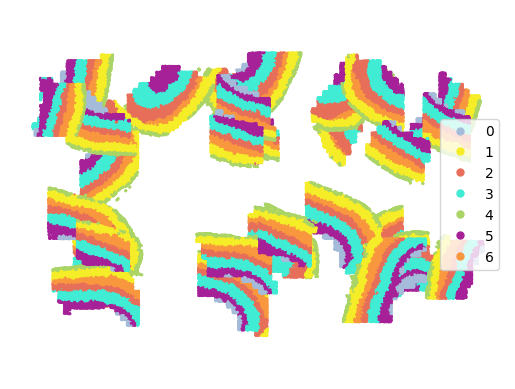

In [5]:
Scube.plot_stacked_slices(adata_list,spatial_key='spatial',cluster_key='spatial_domain')

## Pairwise alignment

在这里，我们执行切片的成对对齐。`cluster_key` 是 `.obs` 的一列，其中包含用于对齐的 spatial domain 信息。`n_neighbors` 影响计算两个切片的相似度时考虑的邻居数量。`knn_exclude_cutoff` 影响邻居的最大距离。默认情况下，`n_neighbors = 15` 和 `knn_exclude_cutoff = n_neighbors` 表示源切片中的一个 spot/cell 考虑目标切片中的 15 个 neighbors，当 neighbors 距离大于所有 spot/cell 中最近 30 个 neighbors 距离的中位数时，邻居将被排除目标切片。`p` 影响重叠惩罚的指数，p 越大，部分对齐能力越强。

In [7]:
Scube.align(adata_list,
      cluster_key='spatial_domain',
      n_neighbors = 15,
      n_threads=10,
      p=2,
      write_loc_path='Scube_outputs/aligned_coordinates.csv'
     )
sc.concat(adata_list).write('data/merfish_mouse_brain/merfish_mouse_brain.h5ad')

Start alignment...
Alignment slice 1 to 0
Alignment slice 2 to 1
Alignment slice 3 to 2
Alignment slice 4 to 3
Alignment slice 5 to 4
Alignment slice 6 to 5
Alignment slice 7 to 6
Alignment slice 8 to 7
Alignment slice 9 to 8
Alignment slice 10 to 9
Alignment slice 11 to 10
Alignment slice 12 to 11
Alignment slice 13 to 12
Alignment slice 14 to 13
Alignment slice 15 to 14
Alignment slice 16 to 15
Alignment slice 17 to 16
Alignment slice 18 to 17
Alignment slice 19 to 18
Alignment slice 20 to 19
Alignment slice 21 to 20
Alignment slice 22 to 21
Alignment slice 23 to 22
Alignment slice 24 to 23
Alignment slice 25 to 24
Alignment slice 26 to 25
Alignment slice 27 to 26
Alignment slice 28 to 27
Alignment slice 29 to 28
Alignment slice 30 to 29
Alignment slice 31 to 30
Alignment slice 32 to 31
Runtime: 1360.7527182102203 s


对齐后，新的 spots/cells 位置坐标保存在每个切片的 anndata 对象的 `.obsm['spatial_aligned']` 中。当用户提供 `write_loc_path` 时，所有切片的所有 spots/cells 的位置坐标将保存在 `write_loc_path` 中。

## Plot alignment results

绘制堆叠在单个图中的所有对齐切片。

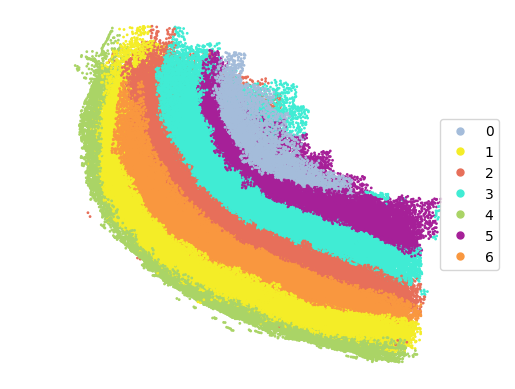

In [8]:
Scube.plot_stacked_slices(adata_list,spatial_key='spatial_aligned',cluster_key='spatial_domain')

将所有对齐坐标和颜色的 spots/cells 保存在一个 DataFrame 中。

In [9]:
coo = pd.DataFrame()
for i in range(len(adata_list)):
    loc = adata_list[i].obsm['spatial_aligned'].copy()
    loc['Z'] = i
    loc['celltype_colors'] = adata_list[i].obs['spatial_domain'].replace(dict(zip([4,1,6,2,3,5,0],['#aad466', '#f4ed27','#f9973f','#e76f5a','#40ecd4', '#a62098', '#a4bcda'])))
    coo = pd.concat([coo,loc],axis=0)
coo.to_csv('Scube_outputs/aligned_coordinates_colors.csv')

绘制由 Scube 构建的 3D 堆叠的所有对齐切片

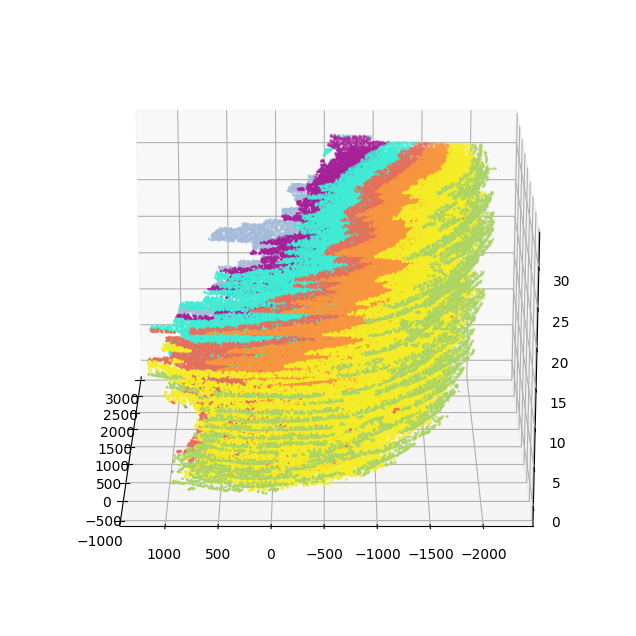

In [10]:
Scube.plot_3d(coo.values[:,:3],val=None,color=coo['celltype_colors'],show=True,elev=20,azim=180,s=1)